# Principal Component Analysis

Hypothesis: Regimes 3 and 5 are the most similar. Will this show up in a PCA plot?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
import matplotlib.cm as cmx
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from Notebook_helpers import load_data
from Notebook_helpers.modeling_helpers import *

%matplotlib inline

# Load Data

In [2]:
# df, train, val, test = load_data.load_coral_data(complete=True, CV=False, convert_to_categorical=True)
df, train, test = load_data.load_coral_data(complete=True, CV=True, convert_to_categorical=True)
print(train.shape)
# print(val.shape)

(496, 46)


# Data Prep

In [5]:
# isolate the predictors and labels for both the training and test set
train_X = train.iloc[:, 14:34]
train_X_orig = train_X.copy()
train_y = train['Regime']
train_X_orig = train_X_orig.join(train_y)

pred_names = train.iloc[:, 14:34].columns
pred_names

Index(['Effluent', 'Sedimentation', 'New_Development', 'Habitat_Modification',
       'Invasive_Algae', 'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth'],
      dtype='object')

In [4]:
train.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id_spatial', 'Long', 'Lat', 'Island',
       'Coral', 'CCA', 'Turf', 'Macro', 'Other', 'Grazers', 'Scrapers',
       'Browsers', 'Predators', 'Secondary', 'Effluent', 'Sedimentation',
       'New_Development', 'Habitat_Modification', 'Invasive_Algae',
       'Fishing_Comm_Total', 'Fishing_NonComm_Boat_Total',
       'Fishing_NonComm_Shore_Line', 'Fishing_NonComm_Shore_Net',
       'Fishing_NonComm_Shore_Spear', 'SST_CLIM_M', 'SST_STD', 'CHL_CLIM_M',
       'CHL_ANOM_F', 'PAR_CLIM_M', 'PAR_STD', 'WAV_CLIM_M', 'WAV_ANOM_F',
       'Complexity', 'Depth', 'Regime', 'Regime1', 'Regime2', 'Regime3',
       'Regime5', 'sqrt_power_x_compexity', 'log_power_over_depth',
       'complexity_over_depth', 'Irradiance_x_inv_algae', 'both_anomolies'],
      dtype='object')

In [5]:
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_X.values)

# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X.values)
# val_X = scaler.transform(val_X.values)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# PCA

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [53]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[3.85315549 2.56411597]
[0.19226935 0.12794732]
[0.19226935 0.32021667]


In [24]:
finalDf = principalDf.join(train[['Regime']])
finalDf.head()

,principal component 1,principal component 2,Regime
0,-2.091218,-0.012480,3
0,-2.091218,-0.012480,2
1,-2.321550,-0.663405,5
1,-2.321550,-0.663405,2
2,-1.503644,-0.699634,5


# Plot 2d PCA

In [54]:
pca_means = finalDf.groupby('Regime').mean()

In [55]:
pca_means

,principal component 1,principal component 2
Regime,,
1,0.047616,-0.021391
2,0.154179,-0.246142
3,-0.028417,0.153574
5,0.040044,-0.054844


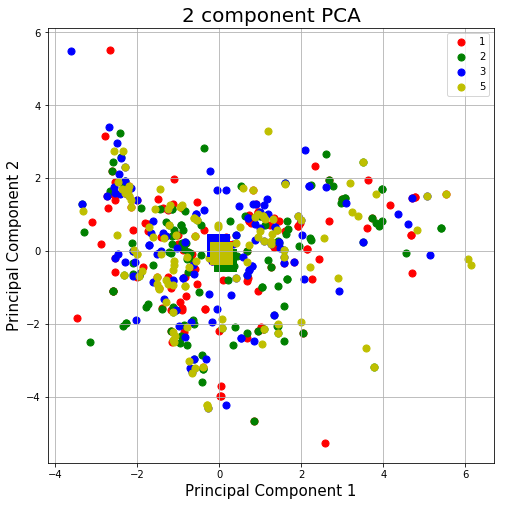

In [63]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 2, 3, 5]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Regime'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
# addPoint(ax, means.iloc[0,:], 'pink')
ax.scatter(pca_means.loc[0, 'principal component 1'], pca_means.loc[0, 'principal component 2'], c='r', s=500, marker='s')
ax.scatter(pca_means.loc[1, 'principal component 1'], pca_means.loc[1, 'principal component 2'], c='g', s=500, marker='s')
ax.scatter(pca_means.loc[2, 'principal component 1'], pca_means.loc[2, 'principal component 2'], c='b', s=500, marker='s')
ax.scatter(pca_means.loc[3, 'principal component 1'], pca_means.loc[3, 'principal component 2'], c='y', s=500, marker='s')
# markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^'
ax.legend(targets)
ax.grid()

In [6]:
train_means = train_X_orig.groupby('Regime').mean()

In [7]:
train_means

,Predators,Secondary,Effluent,Sedimentation,New_Development,Fishing_Comm_Total,Fishing_NonComm_Boat_Total,Fishing_NonComm_Shore_Line,Fishing_NonComm_Shore_Net,Fishing_NonComm_Shore_Spear,SST_CLIM_M,SST_STD,CHL_CLIM_M,CHL_ANOM_F,PAR_CLIM_M,PAR_STD,WAV_CLIM_M,WAV_ANOM_F
Regime,,,,,,,,,,,,,,,,,,
1,1.073063,10.250079,4571.513220,6.194974,0.027846,0.423829,0.982106,4.163765,1.218208,1.874441,27.183159,0.936618,0.109506,0.092798,53.309453,9.148494,18.622387,0.137781
2,10.771000,26.424179,3364.294419,7.736872,0.016384,0.152193,0.319576,3.790581,0.658160,1.196998,26.961949,0.938607,0.108592,0.081055,52.852056,9.270350,34.237986,0.118418
3,8.899508,21.861006,2836.768528,2.923559,0.023478,0.119273,0.444028,7.717909,1.138243,3.373072,27.368802,0.899596,0.088448,0.101964,51.795587,8.782166,13.435914,0.106954
5,5.144826,18.638416,2788.003174,9.469696,0.034567,0.153219,0.366118,9.256014,0.771389,3.293841,27.342925,0.895309,0.093447,0.092671,51.424116,8.592809,13.888860,0.102561
